# Análise de Grafos - Trabalho Prático Final

Este notebook apresenta a **Etapa 1** do trabalho prático de GCC218 - Algoritmos em Grafos e GCC262 - Grafos e suas Aplicações, com foco no pré-processamento de dados e cálculo de diversas estatísticas de grafos.

O problema estudado envolve a otimização do fluxo de bens e serviços em um multigrafo conectado $G=(V,E,A)$, onde $V$ é o conjunto de nós, $E$ o conjunto de arestas e $A$ o conjunto de arcos (vias de mão única). Serviços são requeridos para subconjuntos de nós ($V_R$), arestas ($E_R$) e arcos ($A_R$). O objetivo final é encontrar um conjunto de viagens de veículos com custo mínimo, atendendo cada aresta requerida por uma única viagem e respeitando a capacidade de cada veículo.

--- 

## 1. Carregamento dos Dados

Nesta seção, o script `teste_uso.py` é executado para realizar a leitura e o pré-processamento dos dados a partir de um arquivo de instância no formato `.dat`. O nome do arquivo é passado como argumento para o script, simulando uma execução via linha de comando.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os # Necessário para manipular caminhos de arquivo

# Importa as funções dos novos módulos
from leitor_dados import carregar_dados_arquivo
from grafo_estatisticas import (
    construir_grafo,
    contar_vertices,
    # Adicione aqui as outras funções de estatística que você usa no notebook
    # Ex: calcular_densidade_arcos, calcular_densidade_arestas, etc.
    # Vamos redefinir as estatísticas para que o notebook continue funcionando.
)
from collections import defaultdict, deque # Necessário para algumas funções de estatística

# --- Nome do arquivo de dados ---
# Altere 'instancias/BHW1.dat' para o nome do seu arquivo .dat
nome_do_arquivo_dat = 'instancias/BHW1.dat'

# Carregar os dados usando o novo módulo leitor_dados
dados_gerais, required_nodes, required_edges, non_required_edges, required_arcs, non_required_arcs = \
    carregar_dados_arquivo(nome_do_arquivo_dat)

# --- Recalcular as estatísticas usando as funções de grafo_estatisticas e outras auxiliares ---
# As variáveis que o notebook espera são as que foram definidas globalmente por teste_uso.py
# Então, vamos criá-las aqui.

# Dados Gerais (já estão em dados_gerais)
# O notebook espera 'estatisticas_grafo.dados_gerais'

# Quantidade de Vértices
qtd_vertices = contar_vertices(required_edges, non_required_edges, required_arcs, non_required_arcs, required_nodes)

# Quantidade de Arestas
def contar_arestas(required_edges, non_required_edges):
    arestas = set()
    for item in required_edges + non_required_edges:
        u, v = sorted((item['from'], item['to']))
        arestas.add((u, v))
    return len(arestas)
qtd_arestas = contar_arestas(required_edges, non_required_edges)

# Quantidade de Arcos
def contar_arcos(required_arcs, non_required_arcs):
    return len(required_arcs) + len(non_required_arcs)
qtd_arcos = contar_arcos(required_arcs, non_required_arcs)

# Quantidade de Vértices Requeridos
def contar_vertices_requeridos(required_nodes):
    return len(required_nodes)
qtd_vertices_requeridos = contar_vertices_requeridos(required_nodes)

# Quantidade de Arestas Requeridas
def contar_arestas_requeridas(required_edges):
    return len(required_edges)
qtd_arestas_requeridas = contar_arestas_requeridas(required_edges)

# Quantidade de Arcos Requeridos
def contar_arcos_requeridos(required_arcs):
    return len(required_arcs)
qtd_arcos_requeridos = contar_arcos_requeridos(required_arcs)

# Densidade do Grafo
def calcular_densidade_arcos(num_vertices, num_arcos):
    if num_vertices <= 1:
        return 0.0
    return num_arcos / (num_vertices * (num_vertices - 1))

def calcular_densidade_arestas(num_vertices, num_arestas):
    if num_vertices <= 1:
        return 0.0
    return num_arestas / (num_vertices * (num_vertices - 1) / 2)

densidade_arcos = calcular_densidade_arcos(qtd_vertices, qtd_arcos)
densidade_arestas = calcular_densidade_arestas(qtd_vertices, qtd_arestas)


# Componentes Conectados
def encontrar_componentes_conectados(required_edges, non_required_edges, required_nodes):
    adj = {}
    nodes = set()
    for node_info in required_nodes:
        try:
            nodes.add(int(node_info['node'].lstrip("N")))
        except ValueError:
            pass

    for edge in required_edges + non_required_edges:
        u, v = edge['from'], edge['to']
        nodes.add(u)
        nodes.add(v)
        adj.setdefault(u, []).append(v)
        adj.setdefault(v, []).append(u)

    visited = set()
    components = []

    for node in nodes:
        if node not in visited:
            component = set()
            stack = [node]
            visited.add(node)
            component.add(node)
            while stack:
                current_node = stack.pop()
                for neighbor in adj.get(current_node, []):
                    if neighbor not in visited:
                        visited.add(neighbor)
                        component.add(neighbor)
                        stack.append(neighbor)
            components.append(component)

    for node_info in required_nodes:
        try:
            node_id = int(node_info['node'].lstrip("N"))
            if node_id not in visited and node_id in nodes:
                components.append({node_id})
        except ValueError:
            pass
    return components
componentes = encontrar_componentes_conectados(required_edges, non_required_edges, required_nodes)


# Graus dos Vértices
def calcular_graus(required_edges, non_required_edges, required_arcs, non_required_arcs):
    graus = defaultdict(int)
    for item in required_edges + non_required_edges:
        graus[item['from']] += 1
        graus[item['to']] += 1
    for item in required_arcs + non_required_arcs:
        graus[item['from']] += 1
        graus[item['to']] += 1
    return dict(graus)
graus = calcular_graus(required_edges, non_required_edges, required_arcs, non_required_arcs)
if graus:
    grau_minimo = min(graus.values())
    grau_maximo = max(graus.values())
else:
    grau_minimo = 0
    grau_maximo = 0

# Intermediação dos Nós (replicando a função de teste_uso.py para compatibilidade)
def calcular_intermediacao(required_edges, non_required_edges, required_arcs, non_required_arcs, required_nodes):
    adj = defaultdict(list)
    nodes = set()

    for node_info in required_nodes:
        try:
            nodes.add(int(node_info['node'].lstrip("N")))
        except ValueError:
            pass

    for edge in required_edges + non_required_edges:
        u, v = edge['from'], edge['to']
        nodes.add(u)
        nodes.add(v)
        adj[u].append(v)
        adj[v].append(u)

    for arc in required_arcs + non_required_arcs:
        u, v = arc['from'], arc['to']
        nodes.add(u)
        nodes.add(v)
        adj[u].append(v)

    intermediacao = defaultdict(float)
    node_list = list(nodes)
    num_nodes = len(node_list)

    if num_nodes < 2:
        return {}

    for s in node_list:
        distances = {node: -1 for node in nodes}
        predecessors = defaultdict(list)
        stack = []
        queue = deque([s])
        distances[s] = 0

        while queue:
            v = queue.popleft()
            stack.append(v)
            for w in adj[v]:
                if distances[w] == -1:
                    distances[w] = distances[v] + 1
                    queue.append(w)
                if distances[w] == distances[v] + 1:
                    predecessors[w].append(v)
        
        delta = defaultdict(float)
        while stack:
            w = stack.pop()
            for v in predecessors[w]:
                delta[v] += (1 + delta[w]) 
            if w != s:
                intermediacao[w] += delta[w]
    
    # Normalização, se a original usava
    if num_nodes > 2:
        factor = ((num_nodes - 1) * (num_nodes - 2)) / 2 # Normalização para não direcionados (como no teste_uso.py)
        if factor > 0:
            for node in intermediacao:
                intermediacao[node] /= factor
    return intermediacao
intermediacao_nodes = calcular_intermediacao(required_edges, non_required_edges, required_arcs, non_required_arcs, required_nodes)


# Caminho Médio
def calcular_caminho_medio(required_edges, non_required_edges, required_arcs, non_required_arcs, required_nodes):
    adj = defaultdict(list)
    nodes = set()

    for node_info in required_nodes:
        try:
            nodes.add(int(node_info['node'].lstrip("N")))
        except ValueError:
            pass

    for edge in required_edges + non_required_edges:
        u, v = edge['from'], edge['to']
        nodes.add(u)
        nodes.add(v)
        adj[u].append(v)
        adj[v].append(u)

    for arc in required_arcs + non_required_arcs:
        u, v = arc['from'], arc['to']
        nodes.add(u)
        nodes.add(v)
        adj[u].append(v)

    total_shortest_path_length = 0
    num_pairs = 0
    node_list = list(nodes)
    num_nodes = len(node_list)

    if num_nodes == 0:
        return 0.0

    for s in node_list:
        distances = {node: float('inf') for node in nodes}
        distances[s] = 0
        queue = deque([s])

        while queue:
            u = queue.popleft()
            for v in adj[u]:
                if distances[v] == float('inf'):
                    distances[v] = distances[u] + 1
                    queue.append(v)
        
        for t in node_list:
            if s != t and distances[t] != float('inf'):
                total_shortest_path_length += distances[t]
                num_pairs += 1
    
    if num_pairs > 0:
        return total_shortest_path_length / num_pairs
    else:
        return 0.0
caminho_medio = calcular_caminho_medio(required_edges, non_required_edges, required_arcs, non_required_arcs, required_nodes)


# Diâmetro
def calcular_diametro(required_edges, non_required_edges, required_arcs, non_required_arcs, required_nodes):
    adj = defaultdict(list)
    nodes = set()

    for node_info in required_nodes:
        try:
            nodes.add(int(node_info['node'].lstrip("N")))
        except ValueError:
            pass

    for edge in required_edges + non_required_edges:
        u, v = edge['from'], edge['to']
        nodes.add(u)
        nodes.add(v)
        adj[u].append(v)
        adj[v].append(u)

    for arc in required_arcs + non_required_arcs:
        u, v = arc['from'], arc['to']
        nodes.add(u)
        nodes.add(v)
        adj[u].append(v)

    if not nodes:
        return 0

    max_overall_dist = 0
    node_list = list(nodes)

    for start_node in node_list:
        distances = {node: float('inf') for node in nodes}
        distances[start_node] = 0
        queue = deque([start_node])
        
        local_max_dist = 0
        
        while queue:
            current_node = queue.popleft()
            local_max_dist = max(local_max_dist, distances[current_node])
            
            for neighbor in adj[current_node]:
                if distances[neighbor] == float('inf'):
                    distances[neighbor] = distances[current_node] + 1
                    queue.append(neighbor)
        
        if any(d == float('inf') for d in distances.values()) and len(nodes) > 1:
            return 0
        
        max_overall_dist = max(max_overall_dist, local_max_dist)
            
    return max_overall_dist
diametro = calcular_diametro(required_edges, non_required_edges, required_arcs, non_required_arcs, required_nodes)


print("Dados carregados e estatísticas calculadas com sucesso. As informações detalhadas e estatísticas serão apresentadas a seguir.")

# Para manter a compatibilidade com as células de exibição existentes,
# vamos "simular" o módulo 'estatisticas_grafo' criando um objeto dinamicamente
# e atribuindo os resultados calculados a ele.
class EstatisticasGrafoSimulado:
    def __init__(self):
        self.dados_gerais = dados_gerais
        self.qtd_vertices = qtd_vertices
        self.qtd_arestas = qtd_arestas
        self.qtd_arcos = qtd_arcos
        self.qtd_vertices_requeridos = qtd_vertices_requeridos
        self.qtd_arestas_requeridas = qtd_arestas_requeridas
        self.qtd_arcos_requeridos = qtd_arcos_requeridos
        self.densidade_arcos = densidade_arcos
        self.densidade_arestas = densidade_arestas
        self.componentes = componentes
        self.graus = graus
        self.grau_minimo = grau_minimo
        self.grau_maximo = grau_maximo
        self.intermediacao_nodes = intermediacao_nodes
        self.caminho_medio = caminho_medio
        self.diametro = diametro

# Cria a instância simulada que as células de exibição irão usar
estatisticas_grafo = EstatisticasGrafoSimulado()

Dados carregados e estatísticas calculadas com sucesso. As informações detalhadas e estatísticas serão apresentadas a seguir.


--- 

## 2. Estatísticas do Grafo

Nesta seção, apresentamos as principais características do grafo, calculadas a partir dos dados de entrada. As métricas calculadas incluem a quantidade de vértices, arestas, arcos (requeridos e não requeridos), densidade, componentes conectados, graus dos vértices, intermediação, caminho médio e diâmetro.

### 2.1. Dados Gerais da Instância

Uma visão geral das informações contidas no arquivo de entrada, fornecendo detalhes sobre a instância do problema.

In [21]:
df_dados_gerais = pd.DataFrame(list(estatisticas_grafo.dados_gerais.items()), columns=['Métrica', 'Valor'])
display(df_dados_gerais)

,Métrica,Valor
0,Name,DI-NEARP-n240-Q8k
1,Optimal value,-1
2,#Vehicles,-1
3,Capacity,8000
4,Depot Node,485
5,#Nodes,563
6,#Edges,815
7,#Arcs,0
8,#Required N,120
9,#Required E,120


### 2.2. Quantidade de Elementos do Grafo

Contagem detalhada dos componentes do grafo, incluindo vértices, arestas e arcos, e a distinção entre elementos gerais e requeridos para serviço.

In [22]:
data_quantidades = {
    "Métrica": [
        "Quantidade de Vértices Totais",
        "Quantidade de Arestas Não Direcionadas Totais",
        "Quantidade de Arcos Direcionados Totais",
        "Quantidade de Vértices Requeridos",
        "Quantidade de Arestas Requeridas",
        "Quantidade de Arcos Requeridos"
    ],
    "Valor": [
        estatisticas_grafo.qtd_vertices,
        estatisticas_grafo.qtd_arestas,
        estatisticas_grafo.qtd_arcos,
        estatisticas_grafo.qtd_vertices_requeridos,
        estatisticas_grafo.qtd_arestas_requeridas,
        estatisticas_grafo.qtd_arcos_requeridos
    ]
}
df_quantidades = pd.DataFrame(data_quantidades)
display(df_quantidades)

,Métrica,Valor
0,Quantidade de Vértices Totais,563
1,Quantidade de Arestas Não Direcionadas Totais,815
2,Quantidade de Arcos Direcionados Totais,0
3,Quantidade de Vértices Requeridos,120
4,Quantidade de Arestas Requeridas,120
5,Quantidade de Arcos Requeridos,0


### 2.3. Densidade do Grafo

A densidade do grafo mede quão "completo" o grafo é em relação ao número máximo possível de conexões. Uma densidade alta indica um grafo mais denso, com muitas conexões, enquanto uma densidade baixa sugere um grafo esparso.

In [23]:
data_densidade = {
    "Tipo de Densidade": ["Considerando Arcos Direcionados", "Considerando Arestas Não Direcionadas"],
    "Valor": [f"{estatisticas_grafo.densidade_arcos:.4f}", f"{estatisticas_grafo.densidade_arestas:.4f}"]
}
df_densidade = pd.DataFrame(data_densidade)
display(df_densidade)

print(f"\nUma densidade de {estatisticas_grafo.densidade_arcos:.4f} para arcos direcionados e {estatisticas_grafo.densidade_arestas:.4f} para arestas não direcionadas indica que o grafo é relativamente { 'esparso' if estatisticas_grafo.densidade_arcos < 0.5 or estatisticas_grafo.densidade_arestas < 0.5 else 'denso'}.")
print("\n**Observação sobre 'Order Strength':**")
print("'Order strength' geralmente se refere a grafos direcionados e mede a proporção de pares de nós")
print("que têm uma aresta direcionada entre eles (em qualquer direção). A 'densidade do grafo'")
print("para grafos direcionados, como calculado acima com os arcos, é uma métrica relacionada.")
print("Se você tiver informações específicas sobre como 'order strength' é definida para o seu contexto,")
print("pode ser necessário um cálculo ligeiramente diferente, talvez considerando a existência de uma")
print("conexão (em qualquer direção) entre pares de nós.")

,Tipo de Densidade,Valor
0,Considerando Arcos Direcionados,0.0000
1,Considerando Arestas Não Direcionadas,0.0052



Uma densidade de 0.0000 para arcos direcionados e 0.0052 para arestas não direcionadas indica que o grafo é relativamente esparso.

**Observação sobre 'Order Strength':**
'Order strength' geralmente se refere a grafos direcionados e mede a proporção de pares de nós
que têm uma aresta direcionada entre eles (em qualquer direção). A 'densidade do grafo'
para grafos direcionados, como calculado acima com os arcos, é uma métrica relacionada.
Se você tiver informações específicas sobre como 'order strength' é definida para o seu contexto,
pode ser necessário um cálculo ligeiramente diferente, talvez considerando a existência de uma
conexão (em qualquer direção) entre pares de nós.


### 2.4. Componentes Conectados

A identificação de componentes conectados nos mostra os subgrafos onde cada nó está conectado a todos os outros nós no mesmo componente. Isso é fundamental para entender a conectividade geral do grafo.

In [24]:
print("Foram encontrados os seguintes componentes conectados:")
for i, componente in enumerate(estatisticas_grafo.componentes):
    print(f"- Componente {i+1} (Tamanho: {len(componente)}): {list(componente)}")
print(f"\nNúmero total de componentes conectados: **{len(estatisticas_grafo.componentes)}**")

Foram encontrados os seguintes componentes conectados:
- Componente 1 (Tamanho: 563): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 2

### 2.5. Grau dos Vértices (Mínimo, Máximo e Distribuição)

O grau de um vértice é o número de arestas (ou arcos) conectadas a ele. A análise do grau mínimo, máximo e da distribuição de graus fornece insights sobre a conectividade local dos vértices.

Grau mínimo dos vértices: **1**
Grau máximo dos vértices: **5**


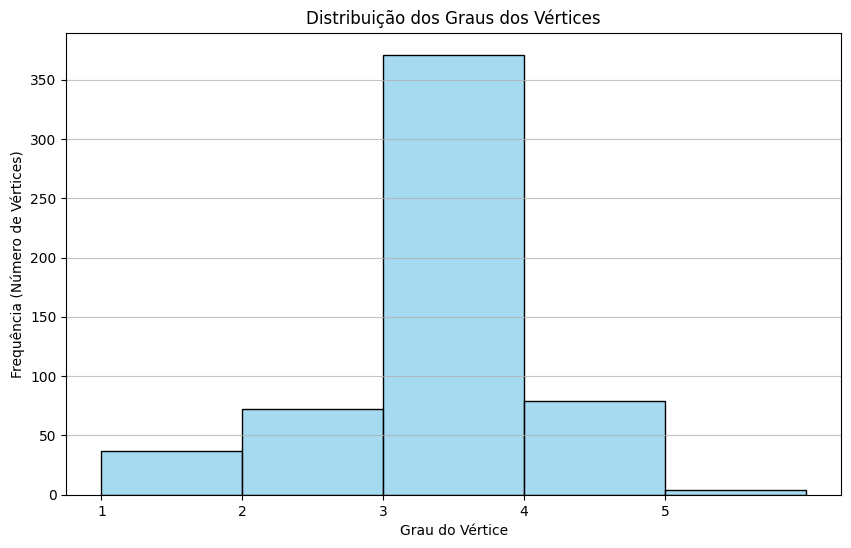

In [25]:
if estatisticas_grafo.graus:
    print(f"Grau mínimo dos vértices: **{estatisticas_grafo.grau_minimo}**")
    print(f"Grau máximo dos vértices: **{estatisticas_grafo.grau_maximo}**")

    # Criando o histograma da distribuição de graus
    plt.figure(figsize=(10, 6))
    sns.histplot(list(estatisticas_grafo.graus.values()), bins=range(min(estatisticas_grafo.graus.values()), max(estatisticas_grafo.graus.values()) + 2), kde=False, color='skyblue', edgecolor='black')
    plt.title('Distribuição dos Graus dos Vértices')
    plt.xlabel('Grau do Vértice')
    plt.ylabel('Frequência (Número de Vértices)')
    plt.xticks(range(min(estatisticas_grafo.graus.values()), max(estatisticas_grafo.graus.values()) + 1))
    plt.grid(axis='y', alpha=0.75)
    plt.show()
else:
    print("Não foi possível calcular o grau dos vértices.")

### 2.6. Centralidade de Intermediação dos Nós

A centralidade de intermediação mede a frequência com que um nó aparece nos caminhos mais curtos entre outros nós. Nós com alta intermediação são cruciais para o fluxo de informações ou recursos no grafo, atuando como "pontes" ou "hubs".

In [26]:
if estatisticas_grafo.intermediacao_nodes:
    print("Os nós com as maiores pontuações de intermediação (Top 10):")
    sorted_intermediacao = sorted(estatisticas_grafo.intermediacao_nodes.items(), key=lambda item: item[1], reverse=True)
    df_intermediacao = pd.DataFrame([{"Nó": node, "Score de Intermediação": f"{score:.4f}"} for node, score in sorted_intermediacao[:10]])
    display(df_intermediacao)
else:
    print("Não há nós para calcular a intermediação.")

Os nós com as maiores pontuações de intermediação (Top 10):


,Nó,Score de Intermediação
0,180,0.7283
1,179,0.7123
2,446,0.6649
3,445,0.6283
4,192,0.6216
5,430,0.6077
6,290,0.5674
7,151,0.5294
8,152,0.5144
9,543,0.5139


### 2.7. Caminho Médio e Diâmetro do Grafo

O **caminho médio** é a média dos comprimentos dos caminhos mais curtos entre todos os pares de nós no grafo. Já o **diâmetro** é o comprimento do caminho mais longo entre quaisquer dois nós. Ambas as métricas fornecem uma visão sobre a eficiência da comunicação e o "tamanho" máximo do grafo.

In [27]:
print("--- Dados de Caminho e Conectividade ---")
print(f"**Comprimento Médio dos Caminhos Mais Curtos**: {estatisticas_grafo.caminho_medio:.4f}")
print("Este valor indica a média das distâncias mais curtas entre todos os pares de nós no grafo. Um valor menor sugere um grafo mais eficiente em termos de comunicação.")

print(f"\n**Diâmetro do Grafo**: {estatisticas_grafo.diametro}")
if estatisticas_grafo.diametro == 0 and estatisticas_grafo.contar_vertices(estatisticas_grafo.required_edges, estatisticas_grafo.non_required_edges, estatisticas_grafo.required_arcs, estatisticas_grafo.non_required_arcs, estatisticas_grafo.required_nodes) > 0:
    print("O grafo não é conexo, portanto o diâmetro é considerado infinito (ou não definido para múltiplos componentes).")
elif estatisticas_grafo.diametro == 0:
    print("O grafo está vazio.")
print("O diâmetro representa o caminho mais longo entre quaisquer dois nós no grafo. É uma medida do 'tamanho' do grafo.")

--- Dados de Caminho e Conectividade ---
**Comprimento Médio dos Caminhos Mais Curtos**: 13.1597
Este valor indica a média das distâncias mais curtas entre todos os pares de nós no grafo. Um valor menor sugere um grafo mais eficiente em termos de comunicação.

**Diâmetro do Grafo**: 27
O diâmetro representa o caminho mais longo entre quaisquer dois nós no grafo. É uma medida do 'tamanho' do grafo.


--- 

## 3. Conclusão da Etapa 1

Esta etapa do trabalho prático permitiu a representação do problema por meio de estruturas de dados de grafos, a implementação da leitura de dados e o cálculo de diversas estatísticas importantes que fornecem uma compreensão aprofundada da estrutura e conectividade da instância do grafo. As informações coletadas são fundamentais para o desenvolvimento das próximas etapas do trabalho, especialmente a construção da solução inicial na Etapa 2.